<a href="https://colab.research.google.com/github/rhehgus02/ESAA_OB/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D(3)_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 7. 앙상블 학습과 랜덤 포레스트**

* 앙상블 학습: 일련의 예측기로부터 예측을 수집해 모델 하나보다 더 좋은 예측을 얻는 것

* 랜덤 포레스트: 결정 트리의 앙상블


---

## **1. 투표 기반 분류기**

* 직접 투표 분류기: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것(다수결)

    -> `voting='hard'`

* 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음

    * 약한 학습기: 랜덤 추측보다 조금 더 높은 성능을 내는 분류기

    * 강한 학습기: 높은 정확도를 내는 분류기

        -> 하지만 이런 가정은 모든 분류기가 독립적이고 오차에 상관관계가 없어야 가능함

* 간접 투표 분류기: 모든 분류기가 클래스의 확률을 예측할 수 있으면(`predict_proba()` 메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음

    -> 이는 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음

    -> `voting='soft'`

In [1]:
# 여러 분류기를 조합하여 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키기

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf',rnd_clf),('svc',svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8666666666666667
RandomForestClassifier 0.9333333333333333
SVC 0.9333333333333333
VotingClassifier 0.9333333333333333


---

## **2. 배깅과 페이스팅**

* 다양한 분류기를 만드는 방법

    * 각기 다른 훈련 알고리즘을 사용하는 것

    * 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것

* 배깅: 훈련 세트에서 중복을 허용하여 샘플링하는 방식

* 페이스팅: 훈련 세트에서 중복을 허용하지 않고 샘플링하는 방식

    -> 배깅과 페이스팅 모두 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있음

* 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦

    -> 수집 함수는 전형적으로 분류일 때는 통계적 최빈값, 회귀일 떄는 평균을 계산함

    -> 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함

* 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음

    -> 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴

---

### **2-1. 사이킷런의 배깅과 페이스팅**

* 사이킷런 API: `BaggingClassifier` / `BaggingRegressor`

    * 배깅: `bootstrap=True`

    * 페이스팅: `bootstrap=False`

    * `n_jobs`: 사이킷런이 훈련과 예측에 사용할 CPU 코어 수

* `BaggingClassifier`는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 직접 투표 대신 자동으로 간접 투표 방식을 사용함

In [4]:
# 결정 트리 분류기 500개의 앙상블을 훈련시키기
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

>> 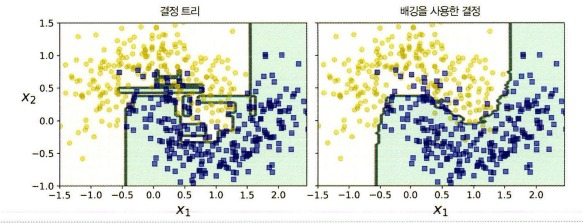

>> 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 됨

>> 앙상블은 비슷한 편향에서 더 작은 분산을 만듦(훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함)

---

### **2-2. obb 평가**

* 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음

    -> 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미함

    -> 선택되지 않은 훈련 샘플의 나머지 37%를 oob 샘플이라고 부름

* 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음

    -> 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음

* `BaggingClassifier`의 `obb_score=True`: 훈련이 끝난 후 자동으로 oob 평가를 수행

    -> 평가 점수 결과는 `oob_score_`에 저장됨

* `obb_decision_function`: obb 샘플에 대한 결정 함수의 값

    -> 결정 함수는 각 훈련 샘플의 클래스 확률을 반환

In [5]:
# obb 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8857142857142857

In [6]:
# 테스트 세트에서의 정확도
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [7]:
# 결정 함수의 값
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.98333333, 0.01666667],
       [0.96132597, 0.03867403],
       [0.        , 1.        ],
       [0.85207101, 0.14792899],
       [0.16216216, 0.83783784],
       [0.90306122, 0.09693878],
       [0.08196721, 0.91803279],
       [0.02923977, 0.97076023],
       [0.5375    , 0.4625    ],
       [0.87434555, 0.12565445],
       [0.        , 1.        ],
       [0.68      , 0.32      ],
       [0.13265306, 0.86734694],
       [0.14754098, 0.85245902],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.91176471, 0.08823529],
       [0.02884615, 0.97115385],
       [0.74456522, 0.25543478],
       [1.        , 0.        ],
       [0.81283422, 0.18716578],
       [0.87046632, 0.12953368],
       [0.93650794, 0.06349206],
       [0.        , 1.        ],
       [0.92708333, 0.07291667],
       [0.11627907, 0.88372093],
       [0.        , 1.        ],
       [0.

---

## **3. 랜덤 패치와 랜덤 서브스페이스**

* `max_features`, `bootstrap`: `BaggingClassifier`의 특성 샘플링 조절

* 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것

* 랜덤 서브스페이스 방식: 훈련 샘플을  모두 사용하고 특성은 샘플링하는 것

    * `bootstrap=False`, `max_samples=1.0`

    * `bootstrap_features=True`, `max_features`는 1보다 작게 설정

---

## **4. 랜덤 포레스트**

* 랜덤 포레스트: 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블

* `RandomForestClassifier`: 편리하게 랜덤 포레스트 사용 가능

* 대부분 `DecisionClassifier`의 매개변수와 앙상블 자체를 제어하는 데 필요한 `BaggingClassifier`의 매개변수를 모두 갖고 있음

* 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함

    -> 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만듦

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [9]:
# BaggingClassifier를 사용해 랜덤포레스트와 거의 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, n_jobs=-1)

---

### **4-1. 엑스트라 트리**

* 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용함

    -> 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함

* 엑스트라 트리: 위와 같이 극단적으로 무작위한 트리의 랜덤 포레스트

    -> 편향이 늘어나지만 대신 분산을 낮춤

* `ExtraTreesClassifier`: 엑스트라 트리를 생성하는 API

---

### **4-2. 특성 중요도**

* 특성의 상대적 중요도: 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함

    -> 더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음

* `feature_importances`: 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화해 저장

In [10]:
# 각 특성의 중요도 출력
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0989790706759896
sepal width (cm) 0.023056915218960472
petal length (cm) 0.44660180113279313
petal width (cm) 0.43136221297225685


---

## **5. 부스팅**

* 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

    -> 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴


### **5-1. 에이다부스트**

* 방식: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것

    -> 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨

* moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계

    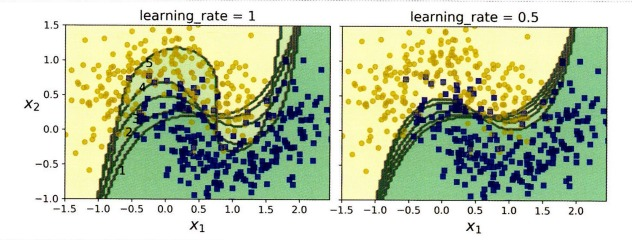

    * 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아짐

        -> 따라서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 됨

    * 오른쪽 그래프는 학습률을 반으로 낮춘 것으로, 잘못 분류된 샘플의 가중치가 반복마다 절반 정도만 높아짐

    * 이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있음

        -> 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다부스트는 앙상블에 예측기를 추가함




* 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦

    -> 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

<에이다부스트 알고리즘>

1. 각 샘플 가중치 $w^{(i)}$는 초기에 $\frac{1}{m} $으로 초기화됨

2. 첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_{1}$이 훈련 세트에 대해 계산됨
    
    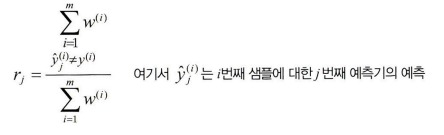

3. 예측기 가중치: $\alpha _{j} =  \eta log \frac{1-r_{j}}{r_{j}} $ ($\eta$: 학습률 하이퍼파라미터)

    -> 예측기가 정확할수록 가중치가 더 높아지게 됨

    -> 무작위로 예측하는 정도라면 가중치가 0에 가까움

4. 가중치 업데이트 규칙을 사용해 샘플의 가중치를 업데이트, 잘못 분류된 샘플의 가중치가 증가됨

    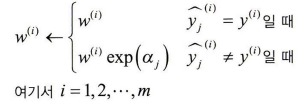

5. 모든 샘플의 가중치를 정규화함

6. 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체 과정이 반복됨

7. 예측을 할 때는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치를 더해 예측 결과를 만듦

    -> 가중치 합이 가장 큰 클래스가 예측 결과가 됨

    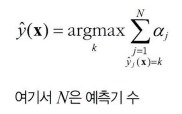



* `SAMME`: 에이다부스트의 다중 클래스 버전

* `SAMME.R`: 예측기가 클래스의 확률을 추정할 수 있다면 사이킷런은 이를 사용

* `AdaBoostClassifier`: 사이킷런의 에이다부스트

In [11]:
# AdaBoostClassifier의 기본 추정기 (max_depth=1)
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

---

### **5-2. 그레디언트 부스팅**

* 그레디언트 부스팅: 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함

    -> 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

* 그레디언트 트리 부스팅 / 그레디언트 부스티드 회귀 트리(GBRT): 결정 트리를 기반 예측기로 사용하는 회귀 예측기

* `GradientBoostingRegressor`: GBRT 앙상블을 간단하게 훈련시킬 수 있음

    * `n_estimators`: 트리 수

    * `max_depth`, `min_samples_leaf`: 결정 트리의 성장을 제어하는 매개변수

    * `learning_rate`: 각 트리의 기여 정도를 조절

        -> 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐 (축소 규제 방법)

        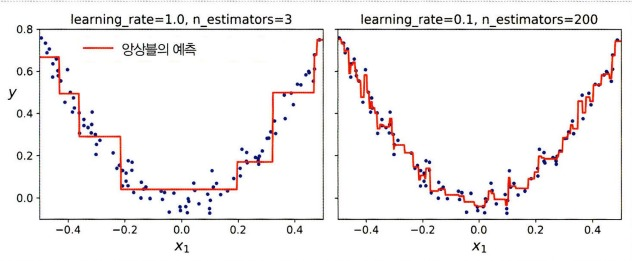

        -> 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면 오른쪽은 트리가 너무 많아 훈련 세트에 과대적합됨

* `staged_predict()`: 최적의 트리 수를 찾기 위해 조기 종료 기법을 구현

    -> 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환

* `warm_start = True`: 사이킷런이 `fit()` 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌

* `subsample`: 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정

    -> `sumbsample=0.25`면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨

    -> 편향이 높아지는 대신 분산이 낮아짐

    -> "확률적 그레디언트 부스팅"이라 함

In [12]:
# DecisionTreeRegressor를 훈련 세트에 학습시키기
from sklearn.tree import DecisionTreeRegressor

tree_reg1 =  DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [13]:
# 첫 번째 예측기에서 생긴 잔여 오차에 DecisionTreeRegressor를 훈련시킴
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [14]:
# 두 번째 예측기에서 생긴 잔여 오차에 세 번째 회귀 모델을 훈련시킴
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

>> 세 개의 트리를 포함하는 앙상블 모델이 생김

In [16]:
# 새로운 샘플에 대한 예측 만들기
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

>> 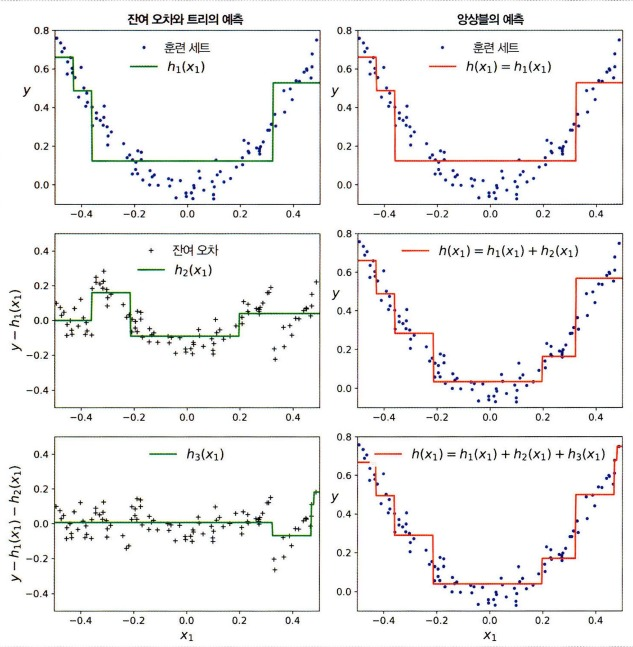

>> 왼쪽 열은 이 세 트리의 예측이고 오른쪽 열은 앙상블의 예측

>> 첫 번째 행에서는 앙상블에 트리가 하나만 있어 첫 번째 트리의 예측과 완전히 같음

>> 두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습되어 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 볼 수 있음

>> 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있음

In [17]:
# GradientBoostingRegressor 사용
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [18]:
# 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정
# 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킴
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118)

>> 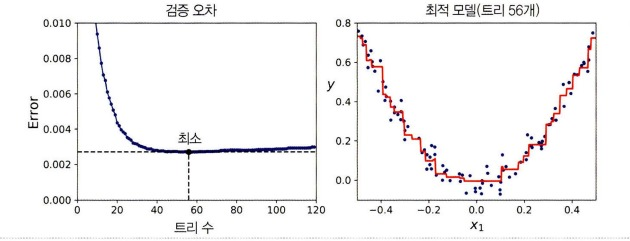

In [20]:
# 실제로 훈련을 중지하는 방법으로 조기 종료 구현
# 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춤
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_goint_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break   # 조기 종료

In [21]:
# XGBoost API
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [22]:
# XGBoost의 자동 조기 종료 기능
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.41896
[1]	validation_0-rmse:0.38165
[2]	validation_0-rmse:0.36936
[3]	validation_0-rmse:0.36897
[4]	validation_0-rmse:0.37291
[5]	validation_0-rmse:0.37811


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


---

## **6. 스태킹**

* 스태킹: 여러 개의 다른 모델들의 예측 결과를 입력으로 사용하여 새로운 메타 모델을 훈련시켜 최종 예측을 생성하는 앙상블 학습 방법

* 블렌더(메티 학습기): 스태킹에서 여러 기본 모델들의 예측을 결합하여 최종 예측을 생성하는 모델

    -> 블렌딩 예측기를 사용한 예측 취합

* 블렌더를 학습시키는 일반적인 방법: 홀드 아웃 세트를 사용

* 훈련 세트를 두 개의 서브셋으로 나눈 후, 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용됨.

* 첫 번째 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만듦. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것임.

* 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있음. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음.

    -> 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습됨.